In [1]:
import numpy as np
import scipy as sp
import math
import torch
import torch.autograd as autograd
import matplotlib.pyplot as plt
import inspect
import textwrap

from typing import Callable
from torch import nn, optim
from data_PINN import diffeq, create_trainig_test_set

import torch.nn.functional as F

In [2]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

In [3]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [4]:
harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

train, test = create_trainig_test_set(harmonic_osc, (0, 10), 100, 1000, 0.3, "RK45", seed=0)

In [5]:
print(train["X"].shape)
print(train["y_tensor"][0:, 0:, 0].unsqueeze(-1).shape)
print(train["t_tensor"].shape)
print(train["args_tensor"].shape)

torch.Size([700, 100, 4])
torch.Size([700, 100, 1])
torch.Size([700, 100])
torch.Size([700, 1])


In [6]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.linear = nn.Linear(in_features=n_in, out_features=32)
        self.linear2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.tanh(self.linear(x))
        x = self.linear2(x)
        return x

# Initiate the model
model = HarmonicModel(4)

In [7]:
def loss_PINN(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)

    t_f = torch.linspace(0, 100, steps=N_f).repeat(len(t), 1).unsqueeze(-1).requires_grad_(True)

    n_rep = int(N_f / len(y_exp[0]))

    k_f = k.unsqueeze(-1).repeat(1, n_rep, 1)
    x_00_f = x_00.unsqueeze(-1).repeat(1, n_rep, 1)
    x_01_f = x_01.unsqueeze(-1).repeat(1, n_rep, 1)

    X_f = torch.cat([k_f, x_00_f, x_01_f, t_f], dim=-1)
    
    y_f = model(X_f)
    x_t = autograd.grad(y_f, t_f,
                       grad_outputs=torch.ones_like(y_f),
                       create_graph=True, allow_unused=True)[0]
    
    x_tt = autograd.grad(x_t, t_f,
                        grad_outputs=torch.ones_like(x_t),
                        create_graph=True, allow_unused=True)[0]
    
    # Residual
    f_res = x_tt + k_f*y_f
    mse_f = torch.mean(f_res**2)

    return mse_y + mse_f

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [9]:
epochs = 100

for epoch in range(epochs):
    X = train["X"]
    y_exp = train["y_tensor"][0:, 0:, 0]
    y_pred = model(X).squeeze(-1)
    t = X[0:, 0:, 3]
    k = X[0:, 0:, 0]
    x_00 = X[0:, 0:, 1]
    x_01 = X[0:, 0:, 2]

    loss = loss_PINN(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % (int(epochs/10)) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 10/100, Loss: 0.7870
Epoch 20/100, Loss: 0.7280
Epoch 30/100, Loss: 0.6836
Epoch 40/100, Loss: 0.6657
Epoch 50/100, Loss: 0.6528
Epoch 60/100, Loss: 0.6413
Epoch 70/100, Loss: 0.6279
Epoch 80/100, Loss: 0.6136
Epoch 90/100, Loss: 0.5981
Epoch 100/100, Loss: 0.5824


In [10]:
model.eval()
X = test["X"]
y_exp = test["y_tensor"][0:, 0:, 0]
y_pred = model(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
#print(T_pred_test)
test_loss = loss_PINN(y_pred, y_exp, x_00, x_01, t, k, N_f=100)
print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.6708


torch.Size([300, 100])


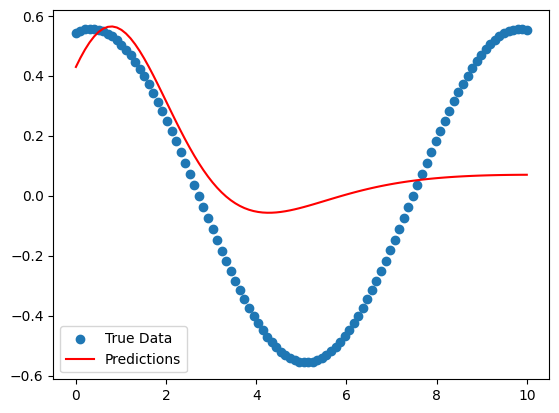

In [11]:
print(y_pred.shape)

n = 10
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test["t_tensor"][n], y_pred.detach()[n], color="red", label="Predictions")
plt.legend()
plt.show()